# Google Trends for investment
#### investigate whether returns for ATVI are correlated with search volume 
    - different types of searches
    

In [1]:
import pandas as pd 
import numpy as np
from pytrends.request import TrendReq # Pseudo Google Search API
import matplotlib.pyplot as plt
import seaborn as sns
import os
import quandl # for financial data
import missingno

### Get ATVI returns data from Quandl
- tutorial: https://medium.com/python-data/quandl-getting-end-of-day-stock-data-with-python-8652671d6661

In [2]:
# Quandl Closing Price time-series
quandl.ApiConfig.api_key = 'ExCsZNkbogxG2ha6ddD-' # Unique

df = quandl.get_table('WIKI/PRICES', ticker = ['ATVI'], 
                        qopts = { 'columns': ['date', 'adj_close'] }, 
                        date = { 'gte': '1990-12-31', 'lte': '2019-12-31' },  # it 
                        paginate=False)
df.date = pd.to_datetime(df.date)
print( 'Start date %s, End date %s'%(df.date.min(),df.date.max()))
df.set_index('date',inplace=True) # set date as index 

Start date 1993-10-25 00:00:00, End date 2018-03-27 00:00:00


In [3]:
# Make data non-stationary by calculating log returns instead of raw prices 

# df['returns'] = np.log(df['adj_close']) - np.log(df['adj_close']).shift(1) # LOG RETURNS 
df['returns'] = df['adj_close'].pct_change()  # SIMPLE RETURNS 
df.head()

,adj_close,returns
date,,
2018-03-27,66.29,NaN
2018-03-26,70.08,0.057173
2018-03-23,68.04,-0.029110
2018-03-22,69.76,0.025279
2018-03-21,71.61,0.026519


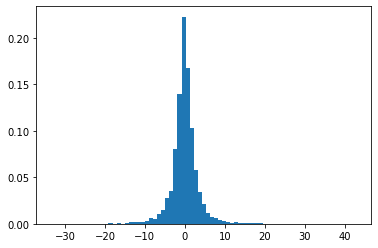

In [4]:
df['percentage_returns'] = df['returns'] * 100
df.dropna(inplace=True)

# RETURNS DISTRIBUTION 
plt.hist(df.percentage_returns,bins=75,density = True); # if density = True (percentage probability), False = frequency 

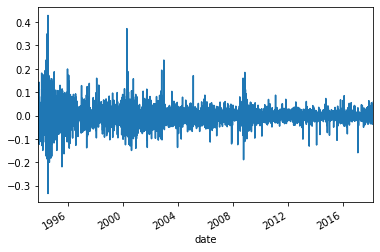

In [5]:
returns  = df['returns'].plot()

### Get Search Data from Google Trends

In [6]:
# GOT RELECANT TERMS FROM GOOGLE TRENDS - https://trends.google.com/trends/explore?q=activision&geo=US
# copied from csv to txt file
terms = open("terms.txt", "r") 
terms = terms.readlines()
terms_l = []
for t in terms:
    terms_l.append(t[:-1])
terms_l[:3]

['activision account', 'blizzard', 'activision blizzard']

#### Similar Terms data is extremely spotty

C:\Users\09ale\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



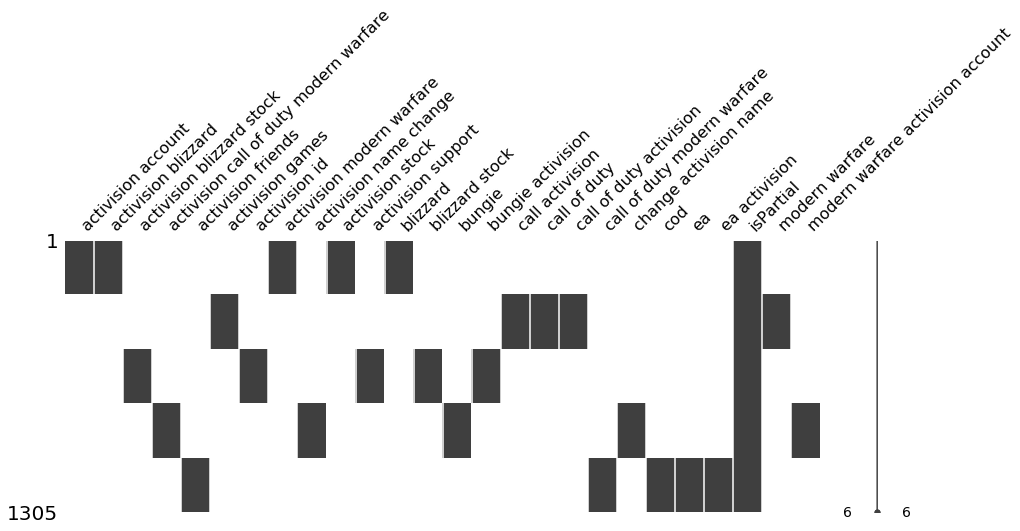

In [7]:
#Start with google trends
pytrend = TrendReq()

# can only look up 5 terms at a time, therefore requires an itterative process to get batches of terms
def batches(iterable, n=1):
    """
    Curtosy of https://stackoverflow.com/questions/8290397/how-to-split-an-iterable-in-constant-size-chunks
    - takes a list and parses it into batches according to n size 
    - returns separate chucks as list
    """
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]
        
# builds a dataframe of search terms 
df_list = []
for x in batches(terms_l, 5):
    # Up to five terms in a list
    pytrend.build_payload(x,geo='US')
    df = pytrend.interest_over_time()
    df_list.append(df)

# Merge all batches into a single DF
df = pd.concat(df_list,axis=0)

# Data Completness
missingno.matrix(df,figsize=(15,5))

#### Custom Terms list

### Correlation Matrix 

In [249]:
### Create Index of top Correlated Terms 